# Práctica Final (I)
## Credit Risk Analysis
### Miembros del grupo: Cristina Rubiales, Lucía Bohórquez, Claudia de la Villa, Jaime Uhagón, Isabel Marsá

### Feature Engineering

El feature engineering es el proceso de manipulación, adición, eliminación, combinación, mutación de un dataset para mejorar el entrenamiento del modelo de aprendizaje automático, lo que lleva a un mejor rendimiento y una mayor precisión. En esta práctica, creamos nuevas variables a partir de las seleccionadas como válidas en la práctica 2. Estas variables añadidas, serán evaluadas con el Information Value (IV), PSI, y la correlación. Por último, se evaluará si la feature diseñada mejora el rendimiento del modelo o no.

El proceso que seguiremos es el siguiente:

1. Identificar la variable objetivo en el conjunto de datos, en este caso la variable 'bad' indica si el cliente ha cometido un fraude o no.

2. Analizar el conjunto de datos para identificar cualquier dato que falte o sea irrelevante, y eliminar o imputar esos valores según sea necesario.

3. Identificar las características más importantes del conjunto de datos, como la puntuación crediticia del prestatario, sus ingresos, su historial laboral y su ratio deuda-ingresos.

4. Crear nuevas features combinando o transformando características existentes, como la creación de una variable nueva que indica los meses transcurridos desde el primer registro del cliente o la creación de una variable categórica para los rangos de ingresos.

5. Utilizar técnicas de selección de características: análisis de correlación, el IV y PSI para identificar las características más predictivas para la variable objetivo.

6. Utilizar las features seleccionadas para construir un modelo de aprendizaje automático

7. Evaluar el rendimiento del modelo utilizando métricas como la exactitud, la precisión y la recuperación.

8. Iterar y ajustar el modelo según sea necesario para mejorar su rendimiento.


In [1]:
# Librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
%matplotlib inline


#import warnings
# warnings.filterwarnings("ignore")

In [2]:
# Leemos los datos
df = pd.read_csv('prosperLoanData_train.csv')
df_val = pd.read_csv('prosperLoanData_val.csv')
df_oot = pd.read_csv('prosperLoanData_oot.csv')

/var/folders/p7/rp06fk690qxbl3rw72b__6w00000gn/T/ipykernel_1975/182420052.py:2: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



#### Análisis Exploratorio de los Datos

In [3]:
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,InvestmentFromFriendsAmount,Investors,LoanMonthsSinceOriginationY,LoanFirstDefaultedCycleNumberQ,bad_aux,PW,fraud,bad,indeterm,LoanOriginationYear
0,17BE353394862694216668A,543539,2011-12-08 14:14:48.073000000,NaN,36,Completed,2014-02-13 00:00:00,0.35285,0.3127,0.3027,...,0.0,7,2.0,NaN,False,True,False,False,False,2011
1,9967350949242729597D81B,495347,2011-02-22 18:34:18.067000000,NaN,36,Chargedoff,2012-04-10 00:00:00,0.35643,0.3199,0.3099,...,0.0,65,3.0,12.0,True,True,False,False,True,2011
2,316134588842865403AC012,419801,2009-08-07 16:37:06.763000000,NaN,36,Completed,2011-11-22 00:00:00,0.39153,0.3500,0.3400,...,0.0,19,5.0,NaN,False,True,False,False,False,2009
3,26883516458683839970CEC,509858,2011-06-03 09:46:22.647000000,NaN,36,Completed,2012-08-02 00:00:00,0.35643,0.3199,0.3099,...,0.0,51,3.0,NaN,False,True,False,False,False,2011
4,A1E73529620250506EDF56D,534924,2011-10-23 08:34:55.960000000,NaN,36,Current,NaN,0.20200,0.1799,0.1699,...,0.0,36,2.0,NaN,False,True,False,False,False,2011


In [4]:
# Obtenemos información de cada una de las variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16987 entries, 0 to 16986
Data columns (total 89 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ListingKey                           16987 non-null  object 
 1   ListingNumber                        16987 non-null  int64  
 2   ListingCreationDate                  16987 non-null  object 
 3   CreditGrade                          10 non-null     object 
 4   Term                                 16987 non-null  int64  
 5   LoanStatus                           16987 non-null  object 
 6   ClosedDate                           11864 non-null  object 
 7   BorrowerAPR                          16987 non-null  float64
 8   BorrowerRate                         16987 non-null  float64
 9   LenderYield                          16987 non-null  float64
 10  EstimatedEffectiveYield              16897 non-null  float64
 11  EstimatedLoss               

Para asegurarnos de que el modelo que vamos a construir no esta sobre ajustado, utilizaremos en la práctica tres datasets: 

En el dataframe de validación out of time (**df_oot**) reservamos una muestra que transcurre en un periodo de tiempo distinto al de la muestra de desarrollo, en este caso datos a partir de 2012. Habitualmente se utiliza una muestra reciente y se actualiza la variable a explicar una vez finalizado el modelo. Nos será util porque al validar con una muestra más reciente, probamos la efectividad del modelo con una cartera más similar a la que deberá responder. Además los resultados son más fáciles de interpretar.

En el dataframe de validación (**df_val**) reservamos una muestra que no incluimos en el desarrollo, en este caso un 20% de los datos seleccionado aleatoriamente. 


In [5]:
df.groupby('bad').size()

bad
False    15927
True      1060
dtype: int64

Observamos que en el dataset tenemos un total de 15,927 marcados como "buenos" y 1,060 como "malos".

In [6]:
# Analizamos variables de tipo fecha
df[["ListingCreationDate", "FirstRecordedCreditLine"]].dtypes

ListingCreationDate        object
FirstRecordedCreditLine    object
dtype: object

Observamos que las columnas ListingCreationDate y FirstRecordedCreditLine son de tipo object, por lo que las tendremos que pasar a tipo datetime. A partir de estas dos variables podremos por ejemplo crear dos variables que nos indiquen los meses transcurridos.

A continuación, diferenciaremos entre las variables útiles y el resto de variables. Para ello crearemos un array a partir de las variables seleccionadas como no útiles en la práctica 2. Crearemos una lista llamada "features" donde insertaremos las columnas válidas.

In [7]:
df_columns = pd.read_excel("Clasificacion_columnas_sol.xlsx")
drop = df_columns.loc[df_columns["Keep/Drop"]=="Drop"].Column.values

In [8]:
drop

array(['ListingKey', 'ListingNumber', 'CreditGrade', 'LoanStatus',
       'ClosedDate', 'BorrowerAPR', 'BorrowerRate', 'LenderYield',
       'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn',
       'ProsperRating (numeric)', 'ProsperRating (Alpha)', 'ProsperScore',
       'GroupKey', 'DateCreditPulled', 'LoanKey',
       'LoanCurrentDaysDelinquent', 'LoanFirstDefaultedCycleNumber',
       'LoanMonthsSinceOrigination', 'LoanNumber', 'LoanOriginationDate',
       'LoanOriginationQuarter', 'MemberKey', 'MonthlyLoanPayment',
       'LP_CustomerPayments', 'LP_CustomerPrincipalPayments',
       'LP_InterestandFees', 'LP_ServiceFees', 'LP_CollectionFees',
       'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss',
       'LP_NonPrincipalRecoverypayments', 'InvestmentFromFriendsCount',
       'InvestmentFromFriendsAmount', 'Investors',
       'LoanMonthsSinceOriginationY', 'LoanFirstDefaultedCycleNumberQ',
       'bad_aux', 'PW', 'fraud', 'bad', 'indeterm', 'LoanOriginationYear'],
    

In [9]:
features = [c for c in df.columns 
            if c not in drop]
col_target = 'bad'

In [10]:
features

['ListingCreationDate',
 'Term',
 'ListingCategory (numeric)',
 'BorrowerState',
 'Occupation',
 'EmploymentStatus',
 'EmploymentStatusDuration',
 'IsBorrowerHomeowner',
 'CurrentlyInGroup',
 'CreditScoreRangeLower',
 'CreditScoreRangeUpper',
 'FirstRecordedCreditLine',
 'CurrentCreditLines',
 'OpenCreditLines',
 'TotalCreditLinespast7years',
 'OpenRevolvingAccounts',
 'OpenRevolvingMonthlyPayment',
 'InquiriesLast6Months',
 'TotalInquiries',
 'CurrentDelinquencies',
 'AmountDelinquent',
 'DelinquenciesLast7Years',
 'PublicRecordsLast10Years',
 'PublicRecordsLast12Months',
 'RevolvingCreditBalance',
 'BankcardUtilization',
 'AvailableBankcardCredit',
 'TotalTrades',
 'TradesNeverDelinquent (percentage)',
 'TradesOpenedLast6Months',
 'DebtToIncomeRatio',
 'IncomeRange',
 'IncomeVerifiable',
 'StatedMonthlyIncome',
 'TotalProsperLoans',
 'TotalProsperPaymentsBilled',
 'OnTimeProsperPayments',
 'ProsperPaymentsLessThanOneMonthLate',
 'ProsperPaymentsOneMonthPlusLate',
 'ProsperPrincipalBo

Dividimos entre variables categóricas y numéricas:

In [11]:
cat_features = df[features].select_dtypes(include=["bool", "object"]).columns.tolist()
num_features = [f for f in features if f not in cat_features]

In [12]:
print('categorical features length:',len(cat_features))
print('numerical features length:',len(num_features))


categorical features length: 9
numerical features length: 36


In [13]:
df[num_features].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Term,16987.0,38.547360,9.553738,12.0,36.00,36.000000,36.000000,60.000000
ListingCategory (numeric),16987.0,3.840290,4.103710,0.0,1.00,2.000000,7.000000,20.000000
EmploymentStatusDuration,16982.0,90.379225,89.131565,0.0,27.00,61.000000,126.000000,755.000000
CreditScoreRangeLower,16987.0,701.827280,53.510729,600.0,660.00,700.000000,740.000000,880.000000
CreditScoreRangeUpper,16987.0,720.827280,53.510729,619.0,679.00,719.000000,759.000000,899.000000
CurrentCreditLines,16987.0,9.443398,5.285003,0.0,6.00,9.000000,12.000000,40.000000
OpenCreditLines,16987.0,8.326485,4.740277,0.0,5.00,8.000000,11.000000,34.000000
TotalCreditLinespast7years,16987.0,26.197857,13.843854,2.0,16.00,24.000000,34.000000,120.000000
OpenRevolvingAccounts,16987.0,6.372402,4.224160,0.0,3.00,5.000000,8.000000,33.000000
OpenRevolvingMonthlyPayment,16987.0,355.054630,411.553102,0.0,92.00,225.000000,465.000000,5184.000000


In [14]:
df[cat_features].describe().transpose()

,count,unique,top,freq
ListingCreationDate,16987,16987,2011-12-08 14:14:48.073000000,1
BorrowerState,16987,48,CA,2135
Occupation,16987,67,Other,4460
EmploymentStatus,16987,7,Employed,10647
IsBorrowerHomeowner,16987,2,True,8875
CurrentlyInGroup,16987,2,False,16058
FirstRecordedCreditLine,16987,6428,1993-12-01 00:00:00,40
IncomeRange,16987,7,"$25,000-49,999",5420
IncomeVerifiable,16987,2,True,14992


En este análisis de las variables categóricas y numéricas hemos podido comprobar la necesidad de transformar algunas de las variables. Por ejemplo, la variable IncomeRange es una variable con 7 valores distintos en forma de buckets. Podríamos transformar estos buckets a valores numéricos para una mejor comprensión de los resultados. Las variables FirstRecordedCreditLine Y ListingCreationDate son dos variables categóricas de tipo fecha, que incluye el tiempo también. Hemos considerado que el tiempo es un dato innecesario para nuestro análisis por lo que hemos optado por borrar el tiempo de la fecha. LoanOriginalAmount tiene una desviación típica de 4651.258896, que es un valor muy alto y podríamos separar esta variable en dos valores, según el valor esté por encima o por debajo de la media. La variable TotalCreditLinespast7years es el número de líneas de crédito en los últimos siete años en el momento en que se extrajo el perfil crediticio. Hemos considerado que esta variable aportará más valor a nuestro análisis si la pasamos a datos anuales. A continuación realizamos la transformación de las variables que hemos considerado necesarias:



## Feature Engineering

1. Hemos transformado IncomeRange de buckets a valores numéricos

2. Hemos clasificado los valores de OpenRevolvingAccounts en 4 valores

3. LoanOriginalAmount -> LoanOriginalAmount_med

4. ListingCreationDate y FirstRecordedCreditLine

5. ListingCreationDate_without_time a anual

6. TotalCreditLines7years

Realizaremos también **transformaciones Box Cox** a las variables. Esto consiste en la transformación de nuestras variables que no son no normales en una forma más normal o simétrica. Esto se logra a través de una transformación no lineal de los datos. Para analizar una transformación de Box-Cox, primero se debe calcular el valor óptimo de lambda (λ) que se usará para la transformación. Esto se puede hacer usando una prueba de rango de Box-Cox para encontrar el valor óptimo de lambda. Una vez que se ha encontrado el valor óptimo de lambda, se pueden realizar pruebas estadísticas para verificar si los datos transformados se ajustan a una distribución normal. Estas pruebas pueden incluir la prueba de Anderson-Darling y la prueba de Kolmogorov-Smirnov. Si los resultados de estas pruebas indican que los datos transformados se ajustan a una distribución normal, entonces se puede afirmar que la transformación de Box-Cox ha sido exitosa.

Hemos optado por Box Cox porque mejora la precisión de los resultados de nuestro modelo de riesgo de crédito. Esto se debe a que los modelos se basan en asunciones de normalidad. Básicamente estas transformaciones sirven para corregir varianzas desiguales y para corregir la no linealidad en la relación (mejorar correlación entre las variables).  Recibió este nombre por los estadísticos George E. P. Box y David Cox.

####  1.  IncomeRange 

In [15]:
ordinal_var = {"IncomeRange":{"$25,000-49,999": 6, "$75,000-99,999": 5, "$50,000-74,999": 4, "$100,000+": 3, "$1-24,999": 2, "Not employed": 1, "$0": 0}}

Text(0.5, 1.0, 'Distribución de Ingresos')

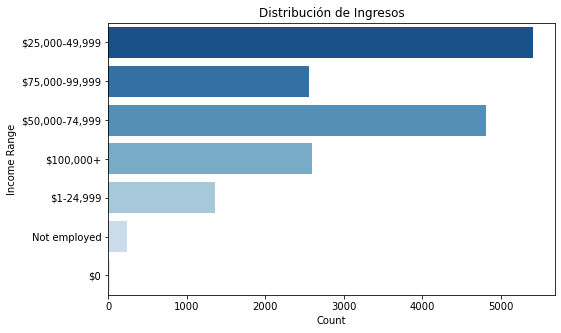

In [16]:
# diagrama de barras
plt.figure(figsize = [8, 5])
sns.countplot(data = df, y = 'IncomeRange', palette = "Blues_r")
plt.ylabel('Income Range')
plt.xlabel('Count')
plt.title('Distribución de Ingresos')


In [14]:
df=df.replace(ordinal_var)
df_oot=df_oot.replace(ordinal_var)
df_val=df_val.replace(ordinal_var)

Text(0.5, 1.0, 'Distribución de Ingresos')

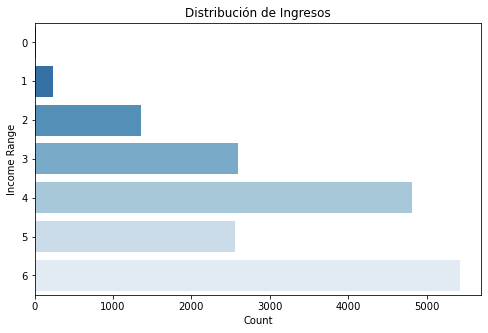

In [15]:
# diagrama de barras
plt.figure(figsize = [8, 5])
sns.countplot(data = df, y = 'IncomeRange', palette = "Blues_r")
plt.ylabel('Income Range')
plt.xlabel('Count')
plt.title('Distribución de Ingresos')


Text(0.5, 1.0, 'Distribución de Ingresos')

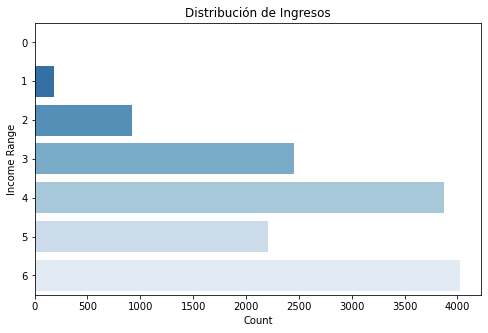

In [16]:
# diagrama de barras
plt.figure(figsize = [8, 5])
sns.countplot(data = df_oot, y = 'IncomeRange', palette = "Blues_r")
plt.ylabel('Income Range')
plt.xlabel('Count')
plt.title('Distribución de Ingresos')

In [17]:
df['OpenRevolvingAccounts'].unique()

array([ 6,  1,  5,  4, 12, 13,  9, 10, 15,  3,  8, 14, 19,  2,  7, 11, 17,
       18, 16,  0, 26, 20, 21, 32, 30, 22, 31, 24, 25, 23, 27, 28, 29, 33])

Text(0.5, 1.0, 'Distribution of Borrower Open Revolving Accounts')

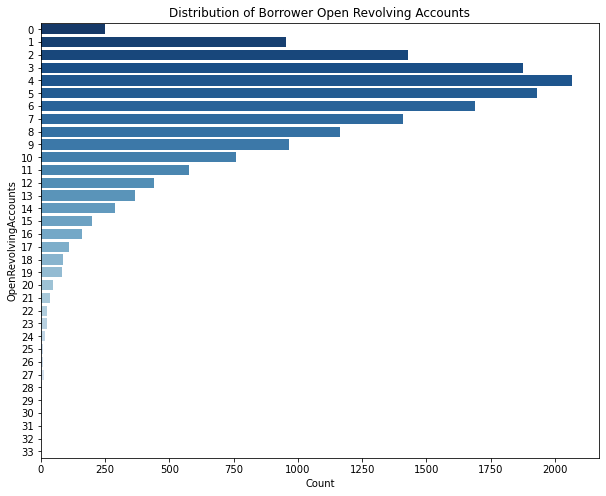

In [9]:
plt.figure(figsize = [10, 8])
sns.countplot(data = df, y = 'OpenRevolvingAccounts', palette = "Blues_r")
plt.ylabel('OpenRevolvingAccounts')
plt.xlabel('Count')
plt.title('Distribution of Borrower Open Revolving Accounts')

#### 2. Open Revolving Accounts

In [10]:
def open_revolving_acounts(x):
    if (x >=0 and x <= 10):
        return 0
    elif ( x >10 and x <= 20):
        return 1
    elif ( x >20 and x <=30):
        return 2
    elif (x> 30 and x <= 33):
        return 3

In [11]:
df['OpenRevolvingAccounts_buckets']= df['OpenRevolvingAccounts'].apply(open_revolving_acounts)
df_oot['OpenRevolvingAccounts_buckets']= df_oot['OpenRevolvingAccounts'].apply(open_revolving_acounts)
df_val['OpenRevolvingAccounts_buckets']= df_val['OpenRevolvingAccounts'].apply(open_revolving_acounts)

Text(0.5, 1.0, 'Distribution of Borrower Open Revolving Accounts')

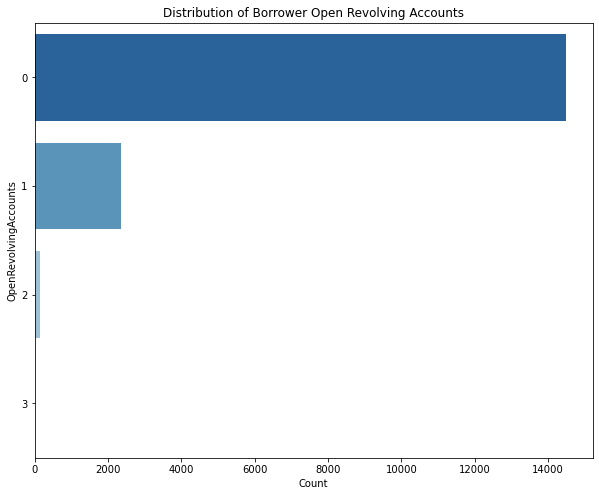

In [13]:
plt.figure(figsize = [10, 8])
sns.countplot(data = df, y = 'OpenRevolvingAccounts_buckets', palette = "Blues_r")
plt.ylabel('OpenRevolvingAccounts')
plt.xlabel('Count')
plt.title('Distribution of Borrower Open Revolving Accounts')

#### 3. Loan Original Amount

In [17]:
loan_mean = df['LoanOriginalAmount'].mean()
loan_mean

6411.536998881497

In [21]:
def loanorig(x):
    if (x >=loan_mean ):
        return 'Above'
    elif (x <=loan_mean):
        return 'Below'

In [22]:
df['LoanOriginalAmount_med']= df['LoanOriginalAmount'].apply(loanorig)
df_val['LoanOriginalAmount_med']= df_val['LoanOriginalAmount'].apply(loanorig)
df_oot['LoanOriginalAmount_med']= df_oot['LoanOriginalAmount'].apply(loanorig)

In [26]:
df[['LoanOriginalAmount_med','LoanOriginalAmount']]

,LoanOriginalAmount_med,LoanOriginalAmount
0,Below,4000
1,Below,4000
2,Below,1000
3,Below,2861
4,Below,3500
...,...,...
16982,Above,15000
16983,Below,5700
16984,Below,5300
16985,Above,15000


#### 4. ListingCreationDate y FirstRecordedCreditLine

In [28]:
df['ListingCreationDate']

0        2011-12-08 14:14:48.073000000
1        2011-02-22 18:34:18.067000000
2        2009-08-07 16:37:06.763000000
3        2011-06-03 09:46:22.647000000
4        2011-10-23 08:34:55.960000000
                     ...              
16982    2011-07-21 10:58:58.330000000
16983    2012-01-18 16:50:49.687000000
16984    2009-11-23 16:12:35.770000000
16985    2011-10-09 12:41:10.470000000
16986    2012-02-20 13:13:24.863000000
Name: ListingCreationDate, Length: 16987, dtype: object

In [29]:
def normalizar_fecha(df, col_date):
    df[col_date] = pd.to_datetime(df[col_date].apply(lambda x: x[:10]))
    
# Normalize FirstRecordedCreditLine, ListingCreationDate columns
normalizar_fecha(df, "ListingCreationDate")
normalizar_fecha(df_val, "ListingCreationDate")
normalizar_fecha(df_oot, "ListingCreationDate")

normalizar_fecha(df, "FirstRecordedCreditLine")
normalizar_fecha(df_val, "FirstRecordedCreditLine")
normalizar_fecha(df_oot, "FirstRecordedCreditLine")

In [30]:
df['ListingCreationDate']

0       2011-12-08
1       2011-02-22
2       2009-08-07
3       2011-06-03
4       2011-10-23
           ...    
16982   2011-07-21
16983   2012-01-18
16984   2009-11-23
16985   2011-10-09
16986   2012-02-20
Name: ListingCreationDate, Length: 16987, dtype: datetime64[ns]

#### 5. ListingCreationDate_without_time

In [31]:
df['ListingCreationDate_without_time'] = df['ListingCreationDate'].dt.strftime('%Y/%m/%d')
df_val['ListingCreationDate_without_time'] = df_val['ListingCreationDate'].dt.strftime('%Y/%m/%d')
df_oot['ListingCreationDate_without_time'] = df_oot['ListingCreationDate'].dt.strftime('%Y/%m/%d')

In [26]:
df=df.drop(['ListingCreationDate','FirstRecordedCreditLine'], axis=1)
df_val=df_val.drop(['ListingCreationDate','FirstRecordedCreditLine'], axis=1)
df_oot=df_oot.drop(['ListingCreationDate','FirstRecordedCreditLine'], axis=1)


#### 6. TotalCreditLines7years

In [34]:
df['TotalCreditLines_year'] = df['TotalCreditLinespast7years']/7

df_val['TotalCreditLines_year'] = df_val['TotalCreditLinespast7years']/7

df_oot['TotalCreditLines_year'] = df_oot['TotalCreditLinespast7years']/7

In [39]:
pd.DataFrame(df['TotalCreditLines_year'])

,TotalCreditLines_year
0,3.142857
1,0.857143
2,2.714286
3,4.714286
4,2.714286
...,...
16982,5.428571
16983,6.142857
16984,4.285714
16985,5.000000


In [28]:
def transform_zeros(x):
    if x == 0:
        return 0.01
    else:
        return x
    
for col in num_features:
    df[col] = df[col].apply(transform_zeros)

for col in num_features:
    df_val[col] = df_val[col].apply(transform_zeros)    

for col in num_features:
    df_oot[col] = df_oot[col].apply(transform_zeros)
    

#### Transformaciones Box Cox

Para realizar la transformaciones Box Cox que hemos mencionado anteriormente, crearemos una función a la que llamamos `boxcox_transform()` y le insertaremos la función de *scipy* `boxcox()` para obtener los resultados buscados.

In [29]:
def boxcox_transform(col):
    
    '''Función que transforma mediante Box Cox las features'''
    
    col_boxcox, _ = stats.boxcox(col)
    return col_boxcox

Aplicamos la función a cada una de las variables transformadas:

In [30]:
tot_trades=boxcox_transform(df['TotalTrades'])
df['TotalTrades_BoxCox']=tot_trades

tot_trades=boxcox_transform(df_val['TotalTrades'])
df_val['TotalTrades_BoxCox']=tot_trades

tot_trades=boxcox_transform(df_oot['TotalTrades'])
df_oot['TotalTrades_BoxCox']=tot_trades

ccl = boxcox_transform(df['CurrentCreditLines'])
df['CurrentCreditLines_BoxCox'] = ccl

ccl = boxcox_transform(df_val['CurrentCreditLines'])
df_val['CurrentCreditLines_BoxCox'] = ccl 

ccl = boxcox_transform(df_oot['CurrentCreditLines'])
df_oot['CurrentCreditLines_BoxCox'] = ccl

ocl=boxcox_transform(df['OpenCreditLines'])
df['OpenCreditLines_BoxCox'] = ocl

ocl=boxcox_transform(df_val['OpenCreditLines'])
df_val['OpenCreditLines_BoxCox'] = ocl

ocl=boxcox_transform(df_oot['OpenCreditLines'])
df_oot['OpenCreditLines_BoxCox'] = ocl


In [31]:
features = [c for c in df.columns 
            if c not in drop]

Insertamos en 'features' todas las variables nuevas, incluyendo las transformaciones Box Cox

In [32]:
features+=['LoanOriginalAmount_med','ListingCreationDate_without_time','CurrentCreditLines_BoxCox','TotalTrades_BoxCox','OpenCreditLines_BoxCox']


cat_features = df[features].select_dtypes(include=["bool", "object"]).columns.tolist()
num_features = [f for f in features if f not in cat_features]

cat_features = df_val[features].select_dtypes(include=["bool", "object"]).columns.tolist()
num_features = [f for f in features if f not in cat_features]

cat_features = df_oot[features].select_dtypes(include=["bool", "object"]).columns.tolist()
num_features = [f for f in features if f not in cat_features]

#### Variables antes y después de la transformación Box Cox

Las distribuciones de las variables no siguen una distribución simétrica por lo que hemos realizado una transformación Box Cox que hemos detallado anteriormente. Realizamos por tanto, una comparación de las distribuciones de las variables originales y las variables tras haberles aplicado la transformación Box Cox:

[Text(0.5, 1.0, 'Total Trades BoxCox')]

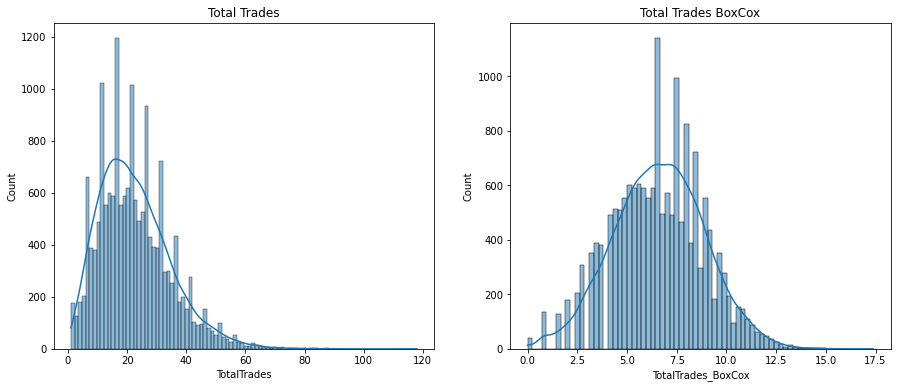

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

sns.histplot(df['TotalTrades'], ax=ax1, kde=True).set(title='Total Trades')
sns.histplot(df['TotalTrades_BoxCox'], ax=ax2, kde=True).set(title='Total Trades BoxCox')

Observamos que la distribución de Total Trades tiene una cola hacia la izquierda. Esto quiere decir que tiene una mayor concentración de los datos en el lado izquierdo, con la mayoría de los valores situados a la izquierda de la media. En cambio, la distribucion de Total Trades tras la transformación Box Cox es una distribución más normal, aunque con algún valor atípico.

[Text(0.5, 1.0, 'Current Credit Lines BoxCox')]

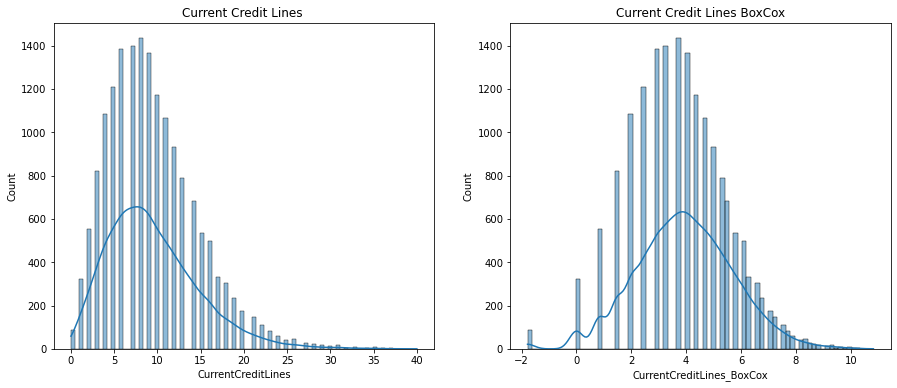

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

sns.histplot(df['CurrentCreditLines'], ax=ax1, kde=True).set(title='Current Credit Lines ') 
sns.histplot(df['CurrentCreditLines_BoxCox'], ax=ax2, kde=True).set(title='Current Credit Lines BoxCox')

En el caso de la variable CurrentCreditLines ocurre algo muy parecido a Total Trades ya que la distribucion de la variable antes de la transformación tiene la cola a la izquierda, por lo que la mayor parte de los datos están situados a la izquierda de la media. 

[Text(0.5, 1.0, 'Open Credit Lines BoxCox')]

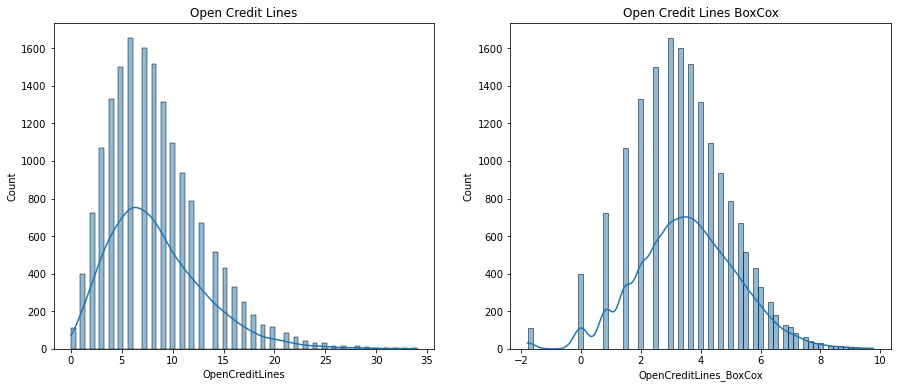

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

sns.histplot(df['OpenCreditLines'], ax=ax1, kde=True).set(title='Open Credit Lines')
sns.histplot(df['OpenCreditLines_BoxCox'], ax=ax2, kde=True).set(title='Open Credit Lines BoxCox')

### Correlación

La correlación es una de las herramientas más fundamentales en el proceso de feature engineering. Puede facilitar la mejora de la precisión del modelos al identificar y eliminar características redundantes, detectar relaciones entre características y objetivos y aislar características que son significativas para el problema de predicción. Por tanto, el análisis de correlación mejorará el rendimiento del modelo y reduce la complejidad del modelo.

A continuación definimos la variable *corr* que realiza la correlación entre las variables numéricas con la función `.corr`. Con esta variable creamos el mapa de calor para visualizar las correlaciones con la función de seaborn `.heatmap`.

/var/folders/p7/rp06fk690qxbl3rw72b__6w00000gn/T/ipykernel_1258/477167481.py:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



<AxesSubplot:>

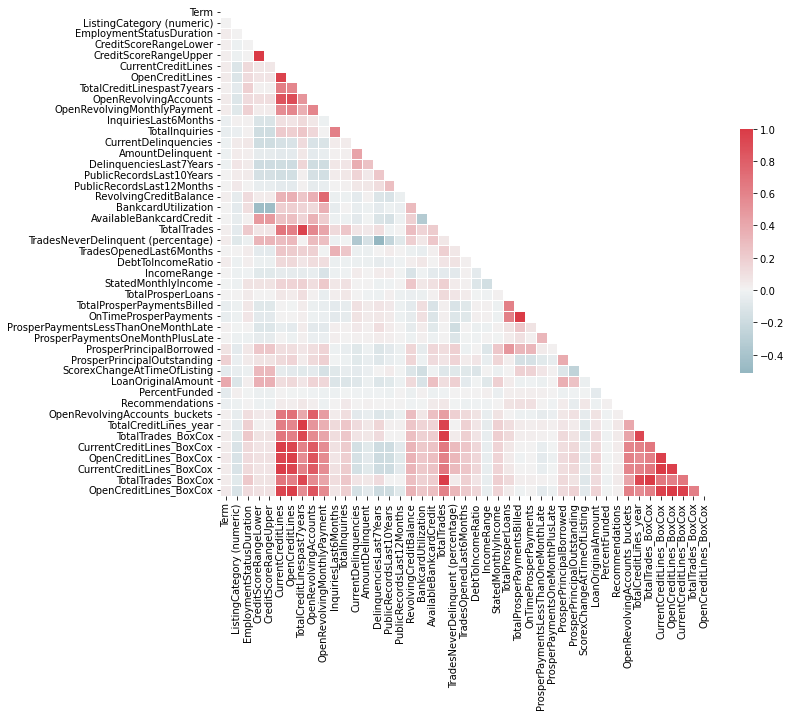

In [36]:
# Definimos corr
corr = df[num_features].corr()
# Parámetros
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [37]:
corr[corr!=1.].max().sort_values().tail()

TotalTrades_BoxCox            0.977928
OnTimeProsperPayments         0.988512
TotalProsperPaymentsBilled    0.988512
TotalCreditLinespast7years    1.000000
TotalCreditLines_year         1.000000
dtype: float64

En el análisis de correlación podemos observar las variables más correlacionadas entre sí. Observamos por un lado que, como esperábamos, las variables están muy correlacionadas con las mismas transformadas. Por ejemplo, CurrentCreditLines y CurrentCreditLines_BoxCox tienen una correlación de 0.976870 y TotalTrades_BoxCox y TotalTrades tienen una correlación de 0.977928.  Por otro lado vemos que OnTimeProsperPayments y TotalProsperPaymentsBilled tienen una correlación muy alta igual a 0.988512. TotalCreditLines_year es la variable que hemos creado a partir de TotalCreditLinespast7years y estas mantienen una correlación positiva perfecta. Por otro lado, observamos una correlación negativa considerablemente alta entre las variables CreditScoreRangeUpper y CreditScoreRangeLower (que son los valores inferiores y superiores que representa el intervalo de la puntuación crediticia del prestatario facilitada por una agencia de calificación) con la variable BankCardUtilization. Hemos considerado que esto se deberá a que cuanto más utilice la tarjeta de crédito el cliente, más baja será la calificación.

### Information Value (IV)


El IV es una herramienta utilizada en credit scoring que sirve para seleccionar variables a la hora de realizar el modelo predictivo.
Identifica aquellas variables que tienen la mayor influencia en la probabilidad de impago o incumplimiento de una deuda.

A la hora de analizar los valores IV tendremos en cuenta los valores cutoff. Son los umbrales que se utilizan para identificar variables predictoras útiles y aquellas que no lo son. Un IV menor que 0,02 se considera no predictivo, mas de 0,3 es potente y si es mayor a 0,5 es probable que tengamos problemas de sobreajuste, o que haya alguna fuga de información. 

Definición de IV:

$
IV = \sum_{i=1}^{i=n} (DistGood_i - DistBad_i) * \ln(\frac{DistGood_i}{DistBad_i})
$

Donde:
- DistGood en el bucket i representa el ratio entrel número de buenos en el bucket i, y el número total de buenos.
- DistBad representa la misma métrica, pero para los malos.

In [38]:
#visualizacion
def capture_df(feat_col, input_slider, n_bins, df, target_col):
    """
    Maneja el tipo de los datos para generar el dataframe intermedio
    """
    if df[feat_col].dtype in [int, float, np.number]:
        return df_vol_br_num(feat_col, input_slider, n_bins, df, target_col)
    else:
        return df_vol_br_cat(feat_col, input_slider, n_bins, df, target_col)

# volumen / BR df para variables numericas
def df_vol_br_num(feat_col, input_slider, n_bins, df, obj_col):
    """
    Genera el dataframe intermedio con el nº de observaciones y nº de malos por bin (bucket). 
    Específico para variables numéricas.
    """
    #get the numeric input from the dual slider
    perc_sliders = [v/100. for v in input_slider]
    var_lims = df[feat_col].quantile([perc_sliders[0], perc_sliders[1]]).values
    v_min, v_max = var_lims[0], var_lims[1]
    #filter the dataset using the slider input(OBJ COL ES BAD/GOOD...)
    df_cut = df.loc[(df[feat_col] <= v_max) & (df[feat_col] >= v_min)][[obj_col, feat_col]]
    #number of cuts = minumum of n_bins, number of unique values of the variable
    n_cuts = min(int(n_bins), df_cut[feat_col].nunique())
    cuts = [c for c in np.linspace(v_min, v_max, n_cuts + 1)]
    if cuts[-1] < v_max:
        cuts.append(v_max)
    cut_col = feat_col + '_'
    df_cut[cut_col] = pd.cut(df_cut[feat_col], cuts, include_lowest=True)
    #generate aggregated values
    N = df_cut.groupby(cut_col)[feat_col].count().values
    TR = df_cut.groupby(cut_col)[obj_col].mean().values
    cuts = df_cut.groupby(cut_col)[feat_col].count().index.astype(str).values
    #handle NA entries
    if df[feat_col].isna().sum() > 0:
        N = np.append(([df[feat_col].isna().sum()]), N)
        TR = np.append(([df.loc[df[feat_col].isna()][obj_col].mean()]), TR)
        cuts =  np.append(['NA'], cuts)
    #generate global transformation rate
    return (pd.DataFrame({'score': cuts,
                         'Numero': N,
                         'Bad Rate': TR}), df_cut[obj_col].mean())

#capture volume / BR df for categorical variables
def df_vol_br_cat(feat_col, input_slider, n_bins, df, target_col):
    """
    Genera el dataframe intermedio con el nº de observaciones y nº de malos por bin (bucket). 
    Específico para variables categóricas.
    """
    #pick top n_bins levels by volume
    cut_levels = df.groupby(feat_col)[feat_col].count().sort_values(ascending=False)[:int(n_bins)].index.values.tolist()
    df_cut = df.loc[df[feat_col].isin(cut_levels)]
    #capture volumes
    N = df_cut.groupby(feat_col)[feat_col].count().values
    #capture transformations
    TR = df_cut.groupby(feat_col)[target_col].mean().values
    return (pd.DataFrame({'score': df_cut.groupby(feat_col)[feat_col].count().index.astype(str).values,
                         'Numero': N,
                         'Bad Rate': TR}), df_cut[target_col].mean())


def output_graph_update(feat_col, input_slider, n_bins, df, obj_col):
    """
    Genera el plot mostrando la visualización del dataframe intermedio con 
    volumen y tasa de malos por bucket
    """
    #get the df with volume and bad rate
    df_tr, avg_tr = capture_df(feat_col, input_slider, n_bins, df, obj_col)
    #line represents transformation rate
    tr_line = go.Scatter(x = df_tr.cuts,
                         y = df_tr.BR,
                         yaxis = 'y2',
                         name = 'BR')
    #bar represents volume @ cut
    vol_bars = go.Bar(x = df_tr.cuts,
                      y = df_tr.N,
                      name = 'Volume')
    #avg line
    avg_line = go.Scatter(x = df_tr.cuts,
                          y = np.repeat(avg_tr, df_tr.shape[0]),
                          yaxis = 'y2',
                          name = 'AVG BR',
                          line = dict(
                              color = ('rgb(205, 0, 0)')
                                     )
                         )
    #small layout
    layout = go.Layout(
            title = 'BR for ' + feat_col,
            yaxis = dict(title = 'Volume',
                         range = [0, max(df_tr.N)]),
            yaxis2 = dict(title = 'BR',
                         overlaying='y',
                         side='right',
                         range = [0, max(df_tr.BR) + 0.05*max(df_tr.BR)])

        )
    return {'data': [vol_bars, tr_line, avg_line],'layout': layout}

In [39]:
# Ejemplo de una variable cortada en buckets: 'CreditScoreRangeLower'
# Esta variable representa el valor más bajo del rango de puntuación del credito aportado por la agencia de rating

feat = "CreditScoreRangeLower"
df_buckets, avg_ratio = df_vol_br_num(feat, [0, 95], 5, df,'bad') 
df_buckets

,score,Numero,Bad Rate
0,"(599.999, 640.0]",2950,0.083729
1,"(640.0, 680.0]",4782,0.070682
2,"(680.0, 720.0]",4302,0.063459
3,"(720.0, 760.0]",2900,0.054138
4,"(760.0, 800.0]",1523,0.024294


In [40]:
df_buckets["Bad"] = df_buckets["Numero"] * df_buckets["Bad Rate"]
df_buckets["Good"] = df_buckets["Numero"] - df_buckets["Bad"]

n_bads = df_buckets["Bad"].sum()
n_goods = df_buckets["Good"].sum()

df_buckets["Dist_Bad"] = df_buckets["Bad"] / n_bads
df_buckets["Dist_Good"] = df_buckets["Good"] / n_goods
print('Gain Table:')
df_buckets


Gain Table:


,score,Numero,Bad Rate,Bad,Good,Dist_Bad,Dist_Good
0,"(599.999, 640.0]",2950,0.083729,247.0,2703.0,0.234791,0.175463
1,"(640.0, 680.0]",4782,0.070682,338.0,4444.0,0.321293,0.288478
2,"(680.0, 720.0]",4302,0.063459,273.0,4029.0,0.259506,0.261538
3,"(720.0, 760.0]",2900,0.054138,157.0,2743.0,0.149240,0.178059
4,"(760.0, 800.0]",1523,0.024294,37.0,1486.0,0.035171,0.096462


In [41]:
def get_IV(df_buckets, col_vol="Numero", col_BR="Bad Rate"):
    """Funcion que estima el IV de una variable. Devuelve:
        - Estimación del IV (tipo float)
    
    Args:
        df_agg: DataFrame Pandas con el volumen en buckets y tasa de malos
        col_vol: Nombre de la columna con el volumen por bucket
        col_BR: Nombre de la columna con la tasa de malos por bucket
        
    Output:
        Dictionary that contains the main statistics of the feature
    """
    
    df_buckets["Bad"] = df_buckets["Numero"] * df_buckets["Bad Rate"]
    df_buckets["Good"] = df_buckets["Numero"] - df_buckets["Bad"]

    n_bads = df_buckets["Bad"].sum()
    n_goods = df_buckets["Good"].sum()

    df_buckets["Dist_Bad"] = df_buckets["Bad"] / n_bads
    df_buckets["Dist_Good"] = df_buckets["Good"] / n_goods
    
    # filter out buckets that have no bads, as it will return inf for that bucket
    df_f = df_buckets.loc[df_buckets["Bad"] > 0].copy()
    
    # compute the IV
    df_f['woe'] = np.log(df_f["Dist_Good"] / df_f["Dist_Bad"])
    df_f['iv'] = (df_f["Dist_Good"] - df_f["Dist_Bad"]) * df_f['woe']
    
    # return the IV
    return df_f['iv'].sum()

In [42]:
ivs = []
for c in features:
    df_tr, avg_br = capture_df(c, [0., 95.], 5, df, 'bad')
    ivs.append(get_IV(df_tr))
df_iv = pd.DataFrame({'feature': features,
                      'IV': ivs}).sort_values(by='IV', ascending=False)
df_iv

/var/folders/p7/rp06fk690qxbl3rw72b__6w00000gn/T/ipykernel_1258/769255613.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

/var/folders/p7/rp06fk690qxbl3rw72b__6w00000gn/T/ipykernel_1258/769255613.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

/var/folders/p7/rp06fk690qxbl3rw72b__6w00000gn/T/ipykernel_1258/769255613.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

/var/folders/p7/rp06fk690qxbl3rw72b__6w00000gn/T/ipykernel_1258/769255613.py:6: DeprecationWarning:

Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.

/var/folders/p7/rp06fk690qxbl3rw72b__6w00000gn/T/ipykernel_1258/76925561

,feature,IV
31,StatedMonthlyIncome,0.119612
29,IncomeRange,0.117696
34,OnTimeProsperPayments,0.113475
39,ScorexChangeAtTimeOfListing,0.108946
45,ListingCreationDate_without_time,0.108534
51,ListingCreationDate_without_time,0.108534
33,TotalProsperPaymentsBilled,0.106258
38,ProsperPrincipalOutstanding,0.104007
28,DebtToIncomeRatio,0.100742
8,CreditScoreRangeLower,0.087758


In [43]:
df_iv.sort_values(by="IV",ascending=False).feature.values.tolist()

['StatedMonthlyIncome',
 'IncomeRange',
 'OnTimeProsperPayments',
 'ScorexChangeAtTimeOfListing',
 'ListingCreationDate_without_time',
 'ListingCreationDate_without_time',
 'TotalProsperPaymentsBilled',
 'ProsperPrincipalOutstanding',
 'DebtToIncomeRatio',
 'CreditScoreRangeLower',
 'CreditScoreRangeUpper',
 'CurrentCreditLines_BoxCox',
 'CurrentCreditLines_BoxCox',
 'Occupation',
 'CurrentCreditLines',
 'EmploymentStatus',
 'ProsperPaymentsLessThanOneMonthLate',
 'InquiriesLast6Months',
 'OpenCreditLines_BoxCox',
 'OpenCreditLines_BoxCox',
 'OpenCreditLines',
 'TotalProsperLoans',
 'OpenRevolvingAccounts',
 'ProsperPaymentsOneMonthPlusLate',
 'TotalTrades_BoxCox',
 'TotalTrades_BoxCox',
 'IncomeVerifiable',
 'ProsperPrincipalBorrowed',
 'TotalTrades',
 'TradesOpenedLast6Months',
 'BorrowerState',
 'LoanOriginalAmount',
 'TotalCreditLines_year',
 'TotalCreditLinespast7years',
 'CurrentlyInGroup',
 'IsBorrowerHomeowner',
 'AmountDelinquent',
 'CurrentDelinquencies',
 'LoanOriginalAmount

### Population Stability Index (PSI)

El PSI es una medida de cuánto se ha desplazado una población a lo largo del tiempo o entre dos muestras diferentes de una población en un solo número. Para ello, divide las dos distribuciones en cubos y compara los porcentajes de elementos en cada uno de los cubos, lo que da como resultado un único número que puede utilizarse para comprender lo diferentes que son las poblaciones. El PSI generalmente se basa en datos históricos y en variables relacionadas con el historial crediticio, el comportamiento de pago, el estado de la economía y el perfil de riesgo de la entidad de crédito. Las interpretaciones habituales del resultado del PSI son:

- PSI < 0,1: ningún cambio significativo en la población
- PSI < 0,2: cambio moderado de la población
- PSI >= 0,2: cambio significativo de la población

Evaluaremos las variables con esta medida como se muestra a continuación e interpretaremos los resultados de estos valores:

In [44]:
def PSI_numeric(series, in_out_time_series):
    """Returns the population stability index for numerical variables
    
    Args:
        series: Pandas Series, the variable to describe
        in_out_time_series: Pandas Series It contains the in time / out of time series
        
    Returns:
        Estimated PSI
    """
    pd_aux = pd.DataFrame(dict(data = series, in_out = in_out_time_series)).reset_index()
    #capture in time and out of time series
    in_series = pd_aux.loc[pd_aux.in_out == True]['data']
    out_series = pd_aux.loc[pd_aux.in_out == False]['data']

    #base data deciles
    qqs = in_series.quantile(q=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

    #cut the data, based in the base series deciles
    in_series_cut = pd.cut(in_series, sorted(list(set(qqs.values))), include_lowest=True)
    out_series_cut = pd.cut(out_series, sorted(list(set(qqs.values))), include_lowest=True)
    #count volume per bin
    in_grp = in_series_cut.value_counts(dropna=False)
    out_grp = out_series_cut.value_counts(dropna= not (np.nan in in_grp.index.values.tolist()))
    #small fix, so some inf values are fixed
    out_grp[out_grp==0] = 0.01

    #N observations in each series
    N_in = len(in_series_cut)
    N_out = len(out_series_cut)

    #convert to share in each bin
    in_grp = in_grp / N_in
    out_grp = out_grp / N_out

    return sum((in_grp-out_grp)*np.log(in_grp/out_grp))

def PSI_categorical(series, in_out_time_series):
    """Returns the population stability index for categorical variables
    
    Args:
        series: Pandas Series, the variable to describe
        in_out_time_series: Pandas Series It contains the in time / out of time series
        
    Returns:
        Estimated PSI
    """
    pd_aux = pd.DataFrame(dict(data = series, in_out = in_out_time_series)).reset_index()
    #capture in time and out of time series
    in_series = pd_aux.loc[pd_aux.in_out == True]['data']
    out_series = pd_aux.loc[pd_aux.in_out == False]['data']
    
    #count volume per level
    in_grp = in_series.value_counts(dropna=False)
    out_grp = out_series.value_counts(dropna= not (np.nan in in_grp.index.values.tolist()))
    
    #N observations in each series
    N_in = len(in_series)
    N_out = len(out_series)
    
    #convert to share in each bin
    in_grp = in_grp / N_in
    out_grp = out_grp / N_out
    
    #put all together in a df
    df_grp = in_grp.to_frame().join(out_grp.to_frame(), lsuffix = '_in', rsuffix = '_out')
    df_grp = df_grp.fillna(0.000001)

    return sum((df_grp.data_in - df_grp.data_out) * np.log(df_grp.data_in / df_grp.data_out))

Utilizamos la función creada para obtener los valores PSI de cada variable:

In [45]:
psi = []
#capture in time - out of time series
it_oot_series = pd.Series(np.hstack((np.ones(len(df)), np.zeros(len(df_oot)))))
#for all features

for c in features:
    col_series = pd.concat([df[c], df_oot[c]], ignore_index=True)
    if c in cat_features:
        psi.append(PSI_categorical(col_series, it_oot_series))
    else:
        psi.append(PSI_numeric(col_series, it_oot_series))

df_psi = pd.DataFrame({'feature': features,
                       'PSI': psi})
df_psi = df_psi.sort_values(by='PSI')
df_psi

,feature,PSI
42,Recommendations,0.000000e+00
21,PublicRecordsLast12Months,5.352324e-09
41,PercentFunded,2.141008e-08
20,PublicRecordsLast10Years,2.724033e-05
18,AmountDelinquent,7.428038e-05
6,IsBorrowerHomeowner,9.212337e-05
17,CurrentDelinquencies,3.430635e-04
19,DelinquenciesLast7Years,1.055222e-03
43,OpenRevolvingAccounts_buckets,1.538137e-03
27,TradesOpenedLast6Months,1.741962e-03


A la hora de elegir las features que se incluirán en un modelo, algunas pueden tener un gran poder predictivo en el momento de la formación, pero si una característica es propensa a sufrir cambios rápidos en su distribución, puede que no sea una decisión acertada incluirla en el modelo o que requiera un seguimiento más frecuente una vez implantada. El PSI es una forma sencilla de comprobar la volatilidad de los cambios de población de las características comparando las poblaciones de varios periodos de tiempo anteriores.

Observamos que Recommendations tiene un PSI igual a 0, lo cual quiere decir que no hay ningún cambio en la población. Las variables que tienen un PSI más bajo son: PublicRecordsLast12Months, PercentFunded, PublicRecordsLast10Years y AmountDelinquent. Las variables con PSI más alto son: ListingCreationDate_without_time, ListingCreationDate_without_time, EmploymentStatus, LoanOriginalAmount y Term.

### Errores de Feature Engineering

Existes dos errores muy comunes que debemos tener en cuenta a la hora de hacer feature engineering:

 - **Sobreajuste**: Cuando construimos demasiadas características, corremos el riesgo de sobreajustar los datos. Es lo que se conoce como la maldición de la dimensionalidad. En pocas palabras, cuantas más características tenga un modelo, más flexibilidad tendrá para establecer relaciones entre el predictor y la variable objetivo. Esto puede parecer bueno, pero si un modelo tiene demasiada flexibilidad, en cierto sentido se sobreoptimizará en los datos con los que se ha entrenado. Esto dará como resultado una puntuación de alto rendimiento, pero tendrá un rendimiento pobre en datos ocultos o nuevos datos, ya que los nuevos datos tendrán diferencias no observadas en los datos de entrenamiento. Debemos ser conscientes de ello y tener en cuenta las pruebas fuera de muestra a la hora de evaluar las características (durante el paso de selección de características).
 

 - **Fuga de información (*information leakage*):** Si la ingeniería de características no se realiza correctamente, puede producirse una fuga de información. Esto suele implicar la construcción de nuevas características utilizando la variable objetivo. La ingeniería de características debe realizarse siempre con independencia de la variable objetivo y debe incluir únicamente variables predictoras de interés.


In [46]:
feats_sorted = df_iv.feature.values.tolist()

def get_uncorr_feats(corr_data, feats_sorted):
    """Handles the corr_data structure, to drop highlly correlated features
    
    Args:
        corr_data: List of tuples containing the correlation info
        feats_sorted: List, with the features to be sorted / dropped
        
    Returns:
        List with the features that have no correlation
    """
    features_keep = feats_sorted[:1]
    for feat in feats_sorted[1:]:
        #capture the correlation tuple
        crr_data = [crr for crr in corr_data if crr[0] == feat]
        if len(crr_data):
            #if there is a 'hit' with a feature in features_keep, do not include it
            hit = len(set(crr_data[0][2].index.tolist()) & set(features_keep)) > 0
            if hit:
                print ('Drop: ' + feat)
            else:
                features_keep.append(feat)    
        else:
            features_keep.append(feat)
    return features_keep

features_keep = get_uncorr_feats(corr, feats_sorted)

In [47]:
def lowIVFeatures(df_iv, th=0.02):
    """Returns a list with the features that have an IV lower that th
    
    Args:
        df_iv: Pandas Dataframe with the feature name and their corresponding IV
        th: Threshold to be considered when filtering the features
        
    Returns:
        List with features that have an IV lower than the threshold
    """
    return df_iv.loc[df_iv["IV"]<th].feature.tolist()

In [48]:
low_iv_feats = lowIVFeatures(df_iv)

In [49]:
# capture low IV features
low_iv_feats = lowIVFeatures(df_iv)
features_keep_iv = list(set(features_keep) - set(low_iv_feats))
len(features), len(features_keep), len(features_keep_iv)

(55, 55, 33)

In [50]:
def highPSIFeatures(df_psi, TH_PSI=0.25):
    """Returns a list with the features that have a PSI higher that th
    
    Args:
        df_iv: Pandas Dataframe with the feature name and their corresponding IV
        th: Threshold to be considered when filtering the features
        
    Returns:
        List with features that have an IV lower than the threshold
    """
    return df_psi.loc[df_psi["PSI"] > TH_PSI].feature.tolist()

In [51]:
high_psi_features = highPSIFeatures(df_psi)

In [52]:
features_keep_psi = list(set(features_keep) - set(high_psi_features))
len(features), len(features_keep), len(features_keep_psi)

(55, 55, 46)

In [53]:
from sklearn import metrics
def get_auc(y_true, y_pred):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

In [54]:
# Lighther preprocessing
# Handle NAs @ numeric features
# fill with a value lower than its minimum
# We can reuse previopus categorical preprocessing

dtypes = df[features].dtypes
cat_features = df[features].select_dtypes(include=["bool", "object"]).columns.tolist()
num_feats = [f for f in features if f not in cat_features]

def get_nafill_rf_num(df, num_features, gap_min=1e6):
    """Get a dictionary, that will store the value that will be used 
    to fill NAs in numeric data.
    
    Args:
        df: Pandas Dataframe with the input data
        num_features: List with the names of categorical features
        gap_min: Gap between minimum value and filling value
        
    Returns:
        Dictionary, with the following structure:
        {feature1: fill_val1,
         feature2: fill_val2}
    """
    dict_fill = {}
    for num_feat in num_features:
        dict_fill[num_feat] = df[num_feat].min() - gap_min
    return dict_fill
    

def apply_nafill_rf_num(df, dict_fillrf):
    """Given a dictionary with the values to be used in NA filling,
    use it to fill NAs.
    
    Args:
        df: Pandas Dataframe with the input data
        dict_fillrf: Dictionary, that stores filling values
        
    Returns:
        Pandas Dataframe with NA being filled
    """
    df_out = df.copy()
    for num_feat in dict_fillrf.keys():
        df_out.loc[df_out[num_feat].isna(), num_feat] = dict_fillrf[num_feat]
    return df_out

In [55]:
#get dictionary to fill values from train
dict_nafill = get_nafill_rf_num(df, num_feats)
#apply it to train, val and oot
df_train_fill = apply_nafill_rf_num(df, dict_nafill)
df_val_fill = apply_nafill_rf_num(df_val, dict_nafill)
df_oot_fill = apply_nafill_rf_num(df_oot, dict_nafill)

In [56]:
final_features = features_keep_psi
final_features

['StatedMonthlyIncome',
 'CurrentCreditLines_BoxCox',
 'ProsperPaymentsLessThanOneMonthLate',
 'CurrentlyInGroup',
 'OpenRevolvingMonthlyPayment',
 'RevolvingCreditBalance',
 'CurrentDelinquencies',
 'OpenRevolvingAccounts_buckets',
 'TotalCreditLinespast7years',
 'CreditScoreRangeLower',
 'IncomeRange',
 'ListingCategory (numeric)',
 'OpenCreditLines_BoxCox',
 'TotalTrades_BoxCox',
 'BankcardUtilization',
 'AmountDelinquent',
 'TotalProsperPaymentsBilled',
 'ProsperPrincipalOutstanding',
 'CurrentCreditLines',
 'IncomeVerifiable',
 'AvailableBankcardCredit',
 'EmploymentStatusDuration',
 'TotalCreditLines_year',
 'ProsperPrincipalBorrowed',
 'PercentFunded',
 'LoanOriginalAmount_med',
 'PublicRecordsLast10Years',
 'TotalTrades',
 'IsBorrowerHomeowner',
 'PublicRecordsLast12Months',
 'BorrowerState',
 'DelinquenciesLast7Years',
 'DebtToIncomeRatio',
 'Recommendations',
 'InquiriesLast6Months',
 'OnTimeProsperPayments',
 'ProsperPaymentsOneMonthPlusLate',
 'TotalInquiries',
 'OpenCredit

In [57]:
y_tr, y_val, y_oot = df['bad'], df_val['bad'], df_oot['bad']

In [58]:
X_tr = df[final_features]
X_val = df_val[final_features]
X_oot = df_oot[final_features]

In [59]:
X_tr

,StatedMonthlyIncome,CurrentCreditLines_BoxCox,ProsperPaymentsLessThanOneMonthLate,CurrentlyInGroup,OpenRevolvingMonthlyPayment,RevolvingCreditBalance,CurrentDelinquencies,OpenRevolvingAccounts_buckets,TotalCreditLinespast7years,CreditScoreRangeLower,...,ProsperPaymentsOneMonthPlusLate,TotalInquiries,OpenCreditLines,TradesNeverDelinquent (percentage),CreditScoreRangeUpper,Occupation,TotalProsperLoans,OpenRevolvingAccounts,ScorexChangeAtTimeOfListing,TradesOpenedLast6Months
0,3583.333333,3.686900,NaN,False,272.0,10444.0,0.01,0,22.0,660.0,...,NaN,6.00,8.0,1.00,679.0,Other,NaN,6.0,NaN,1.00
1,3500.000000,2.010416,NaN,False,135.0,3192.0,0.01,0,6.0,660.0,...,NaN,1.00,3.0,1.00,679.0,Other,NaN,1.0,NaN,0.01
2,2666.666667,1.470013,0.01,False,217.0,5194.0,1.00,0,19.0,660.0,...,0.01,3.00,3.0,0.61,679.0,Food Service Management,1.0,1.0,19.0,0.01
3,6666.666667,2.487334,NaN,False,60.0,99.0,2.00,0,33.0,700.0,...,NaN,16.00,5.0,0.66,719.0,Tradesman - Mechanic,NaN,6.0,NaN,2.00
4,2833.333333,3.316572,NaN,False,221.0,3690.0,0.01,0,19.0,700.0,...,NaN,0.01,6.0,0.94,719.0,Other,NaN,5.0,NaN,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16982,7083.333333,4.035012,NaN,False,373.0,17516.0,0.01,0,38.0,740.0,...,NaN,7.00,8.0,1.00,759.0,Nurse (RN),NaN,4.0,NaN,1.00
16983,5000.000000,0.000000,NaN,False,25.0,53.0,1.00,0,43.0,760.0,...,NaN,3.00,1.0,0.65,779.0,Professional,NaN,3.0,NaN,1.00
16984,3750.000000,6.068873,NaN,False,204.0,4594.0,1.00,1,30.0,740.0,...,NaN,3.00,15.0,0.96,759.0,Other,NaN,15.0,NaN,2.00
16985,6000.000000,5.265693,0.01,False,295.0,9420.0,0.01,0,35.0,660.0,...,0.01,3.00,6.0,1.00,679.0,Clerical,2.0,6.0,6.0,0.01


In [60]:
df.describe()

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,InvestmentFromFriendsAmount,Investors,LoanMonthsSinceOriginationY,LoanFirstDefaultedCycleNumberQ,LoanOriginationYear,OpenRevolvingAccounts_buckets,TotalCreditLines_year,TotalTrades_BoxCox,CurrentCreditLines_BoxCox,OpenCreditLines_BoxCox
count,16987.000000,16987.000000,16987.000000,16987.000000,16987.000000,16897.000000,16897.000000,16897.000000,16897.000000,16897.000000,...,16987.000000,16987.000000,16987.000000,2788.000000,16987.000000,16987.000000,16987.000000,16987.000000,16987.000000,16987.000000
mean,519379.140872,38.547360,0.251439,0.220769,0.210756,0.181165,0.093394,0.110674,3.703912,6.408830,...,13.158067,94.127980,2.713546,16.124821,2010.995232,0.155943,3.742551,6.603807,3.928659,3.547974
std,51186.249686,9.553738,0.091004,0.084128,0.084137,0.082283,0.055218,0.037541,1.823239,2.294022,...,191.342573,99.505726,0.821747,7.732999,0.910404,0.387451,1.977693,2.298426,1.774772,1.684817
min,149172.000000,12.000000,0.045830,0.040000,0.030000,-0.182700,0.006000,-0.182700,1.000000,1.000000,...,0.000000,1.000000,2.000000,4.000000,2009.000000,0.000000,0.285714,0.000000,-1.782146,-1.786839
25%,484256.500000,36.000000,0.173590,0.144900,0.134900,0.117900,0.052000,0.081700,2.000000,5.000000,...,0.000000,28.000000,2.000000,8.000000,2010.000000,0.000000,2.285714,5.153096,2.919087,2.483304
50%,525109.000000,36.000000,0.272460,0.239900,0.229900,0.175700,0.098000,0.117300,3.000000,7.000000,...,0.000000,63.000000,2.000000,16.000000,2011.000000,0.000000,3.428571,6.657956,4.035012,3.678926
75%,558445.500000,36.000000,0.341050,0.303950,0.293950,0.253400,0.142000,0.140000,5.000000,8.000000,...,0.000000,126.000000,3.000000,20.000000,2012.000000,0.000000,4.857143,8.235423,4.977953,4.666205
max,605416.000000,60.000000,0.413550,0.350000,0.340000,0.319900,0.366000,0.266700,7.000000,10.000000,...,7650.000000,1189.000000,5.000000,40.000000,2012.000000,3.000000,17.142857,17.391902,10.821124,9.770356


In [61]:
df_val.describe() 

,ListingNumber,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),ProsperScore,...,InvestmentFromFriendsAmount,Investors,LoanMonthsSinceOriginationY,LoanFirstDefaultedCycleNumberQ,LoanOriginationYear,OpenRevolvingAccounts_buckets,TotalCreditLines_year,TotalTrades_BoxCox,CurrentCreditLines_BoxCox,OpenCreditLines_BoxCox
count,5662.000000,5662.000000,5662.000000,5662.000000,5662.000000,5640.000000,5640.000000,5640.000000,5640.000000,5640.000000,...,5662.000000,5662.000000,5662.000000,987.000000,5662.000000,5660.000000,5662.000000,5662.000000,5662.000000,5662.000000
mean,519234.529318,38.522077,0.253973,0.223071,0.213061,0.182751,0.094702,0.111545,3.659574,6.379965,...,12.117623,94.909926,2.712292,15.586626,2010.981632,0.153887,3.741005,6.450540,3.942627,3.559774
std,50155.381281,9.603780,0.090677,0.083780,0.083788,0.082817,0.055316,0.037900,1.811589,2.246660,...,245.707281,99.295853,0.817613,7.361386,0.903006,0.389599,1.978828,2.222473,1.826287,1.735557
min,186783.000000,12.000000,0.053350,0.042300,0.032300,-0.181600,0.006000,-0.181600,1.000000,1.000000,...,0.000000,1.000000,2.000000,4.000000,2009.000000,0.000000,0.285714,0.000000,-1.775976,-1.779547
25%,484688.250000,36.000000,0.173590,0.149000,0.139000,0.118250,0.052000,0.084975,2.000000,5.000000,...,0.000000,29.000000,2.000000,8.000000,2010.000000,0.000000,2.285714,5.058598,2.926152,2.489576
50%,524811.000000,36.000000,0.274620,0.246650,0.236650,0.176100,0.099000,0.120000,3.000000,7.000000,...,0.000000,63.000000,2.000000,16.000000,2011.000000,0.000000,3.428571,6.514004,4.047333,3.691339
75%,557182.250000,36.000000,0.345770,0.305800,0.295800,0.253400,0.142000,0.141400,5.000000,8.000000,...,0.000000,129.000000,3.000000,20.000000,2012.000000,0.000000,4.857143,7.877796,4.995477,4.684757
max,605174.000000,60.000000,0.413550,0.360000,0.340000,0.319900,0.366000,0.257000,7.000000,10.000000,...,11000.000000,856.000000,5.000000,40.000000,2012.000000,3.000000,17.714286,17.039876,13.282079,11.636450


In [62]:
df_oot.describe() 

,ListingNumber,CreditGrade,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (numeric),...,InvestmentFromFriendsAmount,Investors,LoanMonthsSinceOriginationY,LoanFirstDefaultedCycleNumberQ,LoanOriginationYear,OpenRevolvingAccounts_buckets,TotalCreditLines_year,TotalTrades_BoxCox,CurrentCreditLines_BoxCox,OpenCreditLines_BoxCox
count,13669.000000,0.0,13669.000000,13669.000000,13669.000000,13669.000000,13669.000000,13669.000000,13669.000000,13669.000000,...,13669.000000,13669.000000,13669.000000,1235.000000,13669.000000,13664.000000,13669.000000,13669.000000,13669.000000,13669.000000
mean,659199.943449,NaN,43.219841,0.245676,0.212669,0.202669,0.191755,0.086533,0.105222,3.805692,...,0.813392,96.445973,1.411954,11.242105,2012.264540,0.193135,3.892353,6.896841,4.160383,3.854773
std,38716.897146,NaN,13.292945,0.078741,0.074542,0.074542,0.068027,0.047742,0.027181,1.790414,...,31.939894,91.708863,0.492205,3.614599,0.441104,0.428040,1.932731,2.219744,1.744837,1.701358
min,548999.000000,NaN,12.000000,0.063770,0.056500,0.046500,0.046000,0.004900,0.032800,1.000000,...,0.000000,1.000000,1.000000,4.000000,2012.000000,0.000000,0.285714,0.000000,-1.780707,-1.767943
25%,625790.000000,NaN,36.000000,0.186370,0.152800,0.142800,0.138100,0.044900,0.088800,2.000000,...,0.000000,33.000000,1.000000,8.000000,2012.000000,0.000000,2.428571,5.436182,2.920729,2.935443
50%,653301.000000,NaN,36.000000,0.247580,0.212700,0.202700,0.195200,0.084900,0.110300,4.000000,...,0.000000,66.000000,1.000000,12.000000,2012.000000,0.000000,3.714286,6.918260,4.037875,3.711374
75%,690667.000000,NaN,60.000000,0.309330,0.273600,0.263600,0.246900,0.122500,0.124600,5.000000,...,0.000000,134.000000,2.000000,16.000000,2013.000000,0.000000,5.000000,8.328315,5.270161,5.018555
max,738960.000000,NaN,60.000000,0.358380,0.330400,0.320400,0.305700,0.172500,0.158800,7.000000,...,3093.300000,608.000000,2.000000,20.000000,2013.000000,3.000000,16.428571,16.469392,13.626192,12.226362


#### XGBoost

XGBoost es un algoritmo de aprendizaje automático que utilizaremos a continuación para aumentar la precisión de nuestro modelo. Es una implementación eficiente de la técnica de árboles de decisión en forma de ensamblado (conjuntos de árboles) para optimizar los resultados. Esto se debe a que el XGBoost es muy eficiente para ajustar los datos de entrada y producir resultados precisos para problemas de aprendizaje automático.

Con XGBoost obtendremos el área bajo la curva (AUC), que es la métrica que nos servirá para comparar el modelo con feature engineering y el modelo anterior. 

- El AUC es básicamente una métrica de evaluación de modelos de aprendizaje automático. Esta métrica se refiere a la cantidad de área bajo la curva ROC (Receiver Operating Characteristic) para un modelo predictivo. La curva ROC describe la relación entre los tasas de verdaderos positivos (TPR) y los falsos positivos (FPR) a medida que cambia el umbral de clasificación. Cuanto más alto el valor de AUC, mejor será el modelo.

In [63]:
from xgboost import XGBClassifier
# Entrenamos con XGBoost-Classifier
xgb = XGBClassifier(max_depth=4,
                    learning_rate=0.05, 
                    n_estimators=300, 
                    min_child_weight=250,
                    n_jobs=4,
                   random_state=1)
pred=xgb.fit(X_tr._get_numeric_data(), np.ravel(y_tr, order='C'))

In [64]:
from sklearn.metrics import classification_report

In [65]:
# Predecimos para cada subset
pred_xgb_tr = xgb.predict_proba(X_tr._get_numeric_data())[:, 1]
pred_xgb_val = xgb.predict_proba(X_val._get_numeric_data())[:, 1] 
pred_xgb_oot = xgb.predict_proba(X_oot._get_numeric_data())[:, 1]
xgb_aucs = get_auc(y_tr, pred_xgb_tr), get_auc(y_val, pred_xgb_val), get_auc(y_oot, pred_xgb_oot)
xgb_aucs

(0.739839284423863, 0.6929146422385677, 0.7032177343201754)

In [66]:
pred_xgb_tr

array([0.07019827, 0.13076971, 0.0596711 , ..., 0.02848664, 0.04402018,
       0.0161224 ], dtype=float32)

Obtenemos a continuación un array con las feature importances:

In [67]:
xgb.feature_importances_

array([0.07638666, 0.06306716, 0.02761899, 0.        , 0.01802195,
       0.03977033, 0.11641515, 0.        , 0.02236502, 0.03750815,
       0.01548934, 0.01928965, 0.03747544, 0.00791338, 0.02221577,
       0.01627373, 0.0128151 , 0.03903315, 0.        , 0.        ,
       0.03148768, 0.01247444, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01118395, 0.        , 0.        ,
       0.05149364, 0.        , 0.04902643, 0.08360869, 0.02345393,
       0.01064746, 0.        , 0.00817063, 0.        , 0.0167101 ,
       0.01977978, 0.08286724, 0.02743699], dtype=float32)

In [68]:
df_tr.columns

Index(['score', 'Numero', 'Bad Rate', 'Bad', 'Good', 'Dist_Bad', 'Dist_Good'], dtype='object')

In [69]:
def apply_bucketing(df, feat_col, cuts):
    """Applies a bucketing schema
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas DataFrame with columns dummy columns
    """
    if df[feat_col].dtypes in (object, bool):
        df_buck = apply_bucketing_cat(df, feat_col, cuts)
    else:
        df_buck = apply_bucketing_num(df, feat_col, cuts)
    return df_buck

In [70]:
def get_bucket_feature(df, feat_col, n_bins=6):
    """Trains bucketing in a feature, whether if it is numerical
    or categorical
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        List with the cuts learned from the data
    """
    if df[feat_col].dtypes in (object, bool):
        cuts = get_bucket_catfeature(df, feat_col, n_bins)
    else:
        cuts = get_bucket_numfeature(df, feat_col, n_bins)
    return cuts

def get_bucketing_allfeatures(df, features, n_bins=6):
    """Trains bucketing in all given features of a dataset
    
    Args:
        df: Pandas Dataframe with the input data
        features: Features which bucketing will be learnt
        n_bins: Cuts that will be applied to the input data
        
    Returns:
        Dict, containing all features and its corresponding
        bucketing. For example:
         {'feature1': cuts1,
          'feature2': cuts2}  
    """
    out_dict = {}
    for feature in features:
        print(feature)
        cuts = get_bucket_feature(df, feature, n_bins)
        out_dict[feature] = cuts
    return out_dict

In [71]:
def get_bucket_catfeature(df, feat_col, n_bins):
    """Cuts a categorical feature in 'n_bins', keeping categories with highest volume
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        n_bins: Number of cuts expected
        
    Returns:
        List with the cuts corresponding to this feature
    """
    cuts = df.groupby(feat_col)[feat_col].count().sort_values(ascending=False)[:int(n_bins)].index.values.tolist()
    
    return cuts

def apply_bucketing_cat(df, feat_col, cuts):
    """Applies bucketing to categorical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    df[cut_col] = df[feat_col]
    df.loc[~df[cut_col].isin(cuts), cut_col] = 'Other'
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], prefix=feat_col, drop_first=True)
    
    return dummies_df

def get_bucket_numfeature(df, feat_col, n_bins, input_slider=(0., 100.)):
    """Cuts a numeric feature in 'n_bins', balacing data in percentiles
    
    Args:
        df: Pandas DataFrame with the input data
        feat_col: Name of the column with the input feature
        obj_col: Name of the column with the target 
        n_bins: Number of cuts expected
        input_slider: Range considered for the bucketing
        
    Returns:
        List with the cuts corresponding to this feature
    """
    #get the numeric input from the dual slider
    perc_sliders = [v/100. for v in input_slider]
    var_lims = df[feat_col].quantile([perc_sliders[0], perc_sliders[1]]).values
    v_min, v_max = var_lims[0], var_lims[1]
    #filter the dataset using the slider input
    df_cut = df.loc[(df[feat_col] <= v_max) & (df[feat_col] >= v_min)][[feat_col]]
    cuts = df_cut[feat_col].quantile(np.linspace(perc_sliders[0], perc_sliders[1], n_bins + 1)).values.tolist()
    cuts = sorted(list(set(cuts)))
    return cuts

def format_dummy_col(feat_col, dummy_col):
    """Handles column names for dummy data
    
    Args:
        feat_col: Name of the column with the input feature
        dummy_col: String of the dummy column 
        
    Returns:
        Dummy column with better formatting
    """
    out = dummy_col.replace("(", "")\
                   .replace("]", "")\
                   .replace(".0", "")\
                   .replace(", ", "|")
    
    return feat_col + '_' + out
    
def apply_bucketing_num(df, feat_col, cuts):
    """Applies bucketing to numerical feature
    
    Args:
        df: Pandas Dataframe with the input data
        feat_col: Name of the column with the input feature
        cuts: Cuts that will be applied to the input data
        
    Returns:
        Pandas dataframe with dummy columns
    """
    cut_col = '{}_cut'.format(feat_col)
    if len(cuts) == 2:
        cuts = [cuts[0], np.mean(cuts), cuts[1]]
    df[cut_col] = pd.cut(df[feat_col], cuts, include_lowest=True, precision=0)
    if df[cut_col].isna().any():
        df[cut_col] = df[cut_col].cat.add_categories(["NA"])
        df[cut_col] = df[cut_col].fillna("NA")
        
    dummies_df = pd.get_dummies(df[cut_col], drop_first=True)
    dummies_df.columns = [format_dummy_col(feat_col, str(col)) for col in dummies_df.columns.values.tolist()]
    
    return dummies_df

In [72]:
dict_bucketing = get_bucketing_allfeatures(df, final_features, n_bins=4)

StatedMonthlyIncome
CurrentCreditLines_BoxCox
ProsperPaymentsLessThanOneMonthLate
CurrentlyInGroup
OpenRevolvingMonthlyPayment
RevolvingCreditBalance
CurrentDelinquencies
OpenRevolvingAccounts_buckets
TotalCreditLinespast7years
CreditScoreRangeLower
IncomeRange
ListingCategory (numeric)
OpenCreditLines_BoxCox
TotalTrades_BoxCox
BankcardUtilization
AmountDelinquent
TotalProsperPaymentsBilled
ProsperPrincipalOutstanding
CurrentCreditLines
IncomeVerifiable
AvailableBankcardCredit
EmploymentStatusDuration
TotalCreditLines_year
ProsperPrincipalBorrowed
PercentFunded
LoanOriginalAmount_med
PublicRecordsLast10Years
TotalTrades
IsBorrowerHomeowner
PublicRecordsLast12Months
BorrowerState
DelinquenciesLast7Years
DebtToIncomeRatio
Recommendations
InquiriesLast6Months
OnTimeProsperPayments
ProsperPaymentsOneMonthPlusLate
TotalInquiries
OpenCreditLines
TradesNeverDelinquent (percentage)
CreditScoreRangeUpper
Occupation
TotalProsperLoans
OpenRevolvingAccounts
ScorexChangeAtTimeOfListing
TradesOpened

In [73]:
# Manejar NAs características numéricas
# rellenar con un valor inferior a su mínimo
# Podemos reutilizar previopus categorical preprocessing

dtypes = df[final_features].dtypes
cat_features = df[final_features].select_dtypes(include=["bool", "object"]).columns.tolist()
num_feats = [f for f in final_features if f not in cat_features]

def get_nafill_rf_num(df, num_features, gap_min=1e6):
    """Get a dictionary, that will store the value that will be used 
    to fill NAs in numeric data.
    
    Args:
        df: Pandas Dataframe with the input data
        num_features: List with the names of categorical features
        gap_min: Gap between minimum value and filling value
        
    Returns:
        Dictionary, with the following structure:
        {feature1: fill_val1,
         feature2: fill_val2}
    """
    dict_fill = {}
    for num_feat in num_features:
        dict_fill[num_feat] = df[num_feat].min() - gap_min
    return dict_fill
    

def apply_nafill_rf_num(df, dict_fillrf):
    """Given a dictionary with the values to be used in NA filling,
    use it to fill NAs.
    
    Args:
        df: Pandas Dataframe with the input data
        dict_fillrf: Dictionary, that stores filling values
        
    Returns:
        Pandas Dataframe with NA being filled
    """
    df_out = df.copy()
    for num_feat in dict_fillrf.keys():
        df_out.loc[df_out[num_feat].isna(), num_feat] = dict_fillrf[num_feat]
    return df_out

In [74]:
dict_nafill = get_nafill_rf_num(df, num_feats)
#apply it to train, val and oot
df_train_fill = apply_nafill_rf_num(df, dict_nafill)
df_val_fill = apply_nafill_rf_num(df_val, dict_nafill)
df_oot_fill = apply_nafill_rf_num(df_oot, dict_nafill)

In [75]:
# Keep each column dummy columns in independednt lists
# Initialize with the numeric data already filled
list_df_tr, list_df_val, list_df_oot = [df_train_fill[num_feats]], [df_val_fill[num_feats]], [df_oot_fill[num_feats]]
# Add the bucketing results of categorical data
for feat in cat_features:
    list_df_tr.append(apply_bucketing(df, feat, dict_bucketing[feat]))
    list_df_val.append(apply_bucketing(df_val, feat, dict_bucketing[feat]))
    list_df_oot.append(apply_bucketing(df_oot, feat, dict_bucketing[feat]))

# Then combine them column-wise
df_tr_preproc_rf = pd.concat(list_df_tr, axis=1)
df_val_preproc_rf = pd.concat(list_df_val, axis=1)
df_oot_preproc_rf = pd.concat(list_df_oot, axis=1)

# Keep the final column names
keep_cols_rf = df_tr_preproc_rf.columns

Tras haber obtenido los valores de la importancia de cada uno de los valores, obtenemos que la variable más importante para la predicción es la variable Recommendations con un valor de 0.115846, seguida por CurrentDelinquencies (0.083200), TotalProsperLoans (0.082462) y StatedMonthlyIncome (0.076013). Las variables menos importantes según estos resultados son por ejemplo TotalCreditLines_year y DebtToIncomeRatio


In [76]:
imp_df=pd.DataFrame({'Feature': keep_cols_rf[:43],
                    'Importance': xgb.feature_importances_})

df_importances= imp_df.sort_values(by='Importance', ascending=False)
df_importances

,Feature,Importance
6,OpenRevolvingAccounts_buckets,0.116415
33,OpenCreditLines,0.083609
41,IncomeVerifiable_True,0.082867
0,StatedMonthlyIncome,0.076387
1,CurrentCreditLines_BoxCox,0.063067
30,OnTimeProsperPayments,0.051494
32,TotalInquiries,0.049026
5,CurrentDelinquencies,0.039770
17,CurrentCreditLines,0.039033
9,IncomeRange,0.037508


Observamos los resultados de feature importante de una forma más visual:

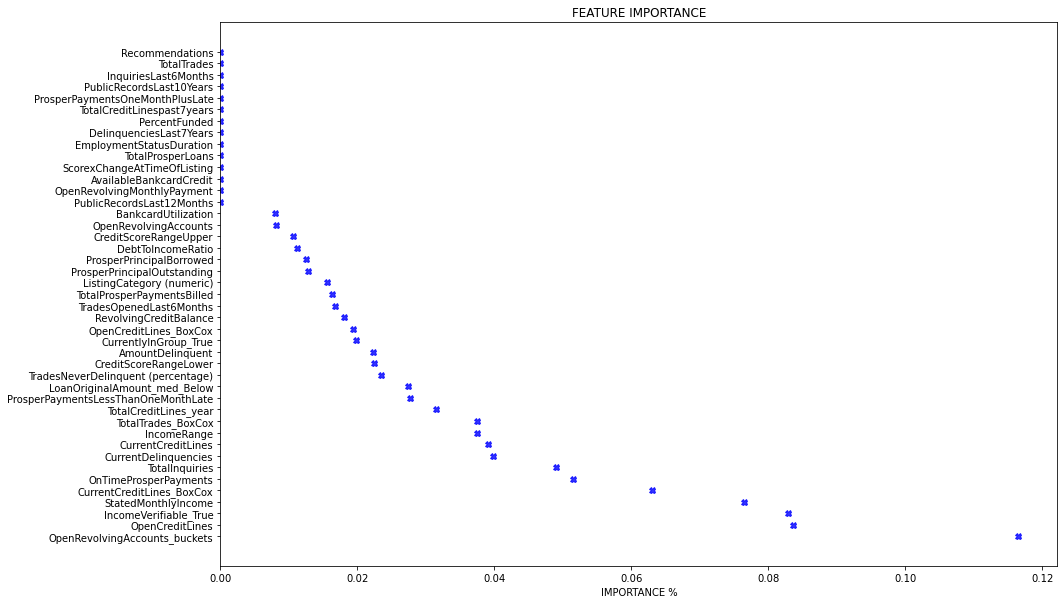

In [77]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.barh(
    df_importances['Feature'],
    df_importances['Importance'],
    
    align='center',
    alpha=0
)
ax.plot(
    df_importances['Importance'],
    df_importances['Feature'],
    marker="X",
    linestyle="",
    alpha=0.8,
    color="b"
)
ax.set_title('FEATURE IMPORTANCE')
ax.set_xlabel('IMPORTANCE %');

In [78]:
xgb_aucs

(0.739839284423863, 0.6929146422385677, 0.7032177343201754)

In [79]:
XGB_AUC_ANTERIOR=(0.7264709048072746, 0.6879442058955243, 0.6918682296469378)

In [80]:
df_aucs = pd.DataFrame([XGB_AUC_ANTERIOR, xgb_aucs])
df_aucs.columns = ["AUC_Train", "AUC_Val", "AUC_OOT"]
df_aucs.index = ["XGB Anterior", "XGB Feature Importance"]
df_aucs

,AUC_Train,AUC_Val,AUC_OOT
XGB Anterior,0.726471,0.687944,0.691868
XGB Feature Importance,0.739839,0.692915,0.703218


Observamos en la tabla que los valores AUC del modelo anterior al feature engineering son más bajos que los del modelo tras realizar el feature importance. Esto quiere decir que el proceso que hemos realizado de feature engineering ha mejorado el modelo ya que cuanto más alto sea el AUC del oot mejor será el modelo. Pero teniendo en cuenta que cuanto mayor sea la diferencia entre los valores de AUC_Train y AUC_OOT peor será, diremos que ha "empeorado" ya que la diferencia entre estos es más grande después de realizar el feature engineering. Pero dicho esto, nos quedaríamos con el modelo nuevo ya que el cambio la diferencia entre estos no es tan grande pero el AUC_OOT ha aumentado que es lo realmente importante.

### Conclusión 

- Hemos aprendido que el feature importance es una técnica de aprendizaje automático que sirve para determinar qué features de un conjunto de datos contribuyen a la predicción de la variable objetivo, en este caso la predicción de que un cliente cometa fraude o no, es decir, se le clasifique como bueno o malo correctamente. 

- Esta técnica ha servido para reducir la dimensión de los conjuntos de datos, eliminando características irrelevantes y reduciendo el tiempo de entrenamiento y la complejidad del modelo.

- Primero, hemos realizado una observación de los datos y hemos utilizado un dataset de validación (df_val) y otro out of time (df_oot).

- Tras analizar las variables, hemos decidido realizar unas transformaciones a los datos, como la sustitución de los buckets de la variable IncomeRange por valores numéricos, o la eliminación del tiempo dentro de variables de tipo fecha.

- Se han evaluado las variables utilizando las herramientas de correlación, IV y PSI. El IV es una herramienta utilizada en credit scoring que sirve para seleccionar variables a la hora de realizar el modelo predictivo y el PSI es una medida de cuánto se ha desplazado una población a lo largo del tiempo o entre dos muestras diferentes de una población en un solo número.

- Con el feature importance hemos obtenido variable más importante para la predicción es la variable Recommendations con un valor de 0.115846, seguida por CurrentDelinquencies (0.083200), TotalProsperLoans (0.082462) y StatedMonthlyIncome (0.076013). Las variables menos importantes según estos resultados son por ejemplo TotalCreditLines_year y DebtToIncomeRatio

- XGBoost es el algoritmo que hemos utilizado para obtener el AUC y así comparar los dos modelos. Hemos obtenido que el nuevo modelo tras aplicarle el feature engineering es mejor que el anterior ya que el AUC aumenta, aunque la diferencia entre el valor de AUC de oot y de validation es más grande en este caso.

